<a href="https://colab.research.google.com/github/invoker-qqwrv/Beida_tensorflow/blob/main/5_15_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

170498071/170498071 [==============================] - 2s 0us/step
Epoch 1/5
1563/1563 [==============================] - 78s 43ms/step - loss: 1.4387 - sparse_categorical_accuracy: 0.5206 - val_loss: 1.4571 - val_sparse_categorical_accuracy: 0.5362
Epoch 2/5
1563/1563 [==============================] - 66s 42ms/step - loss: 0.8819 - sparse_categorical_accuracy: 0.7042 - val_loss: 0.9265 - val_sparse_categorical_accuracy: 0.6851
Epoch 3/5
1563/1563 [==============================] - 66s 42ms/step - loss: 0.6654 - sparse_categorical_accuracy: 0.7817 - val_loss: 0.9813 - val_sparse_categorical_accuracy: 0.6927
Epoch 4/5
1563/1563 [==============================] - 66s 42ms/step - loss: 0.5279 - sparse_categorical_accuracy: 0.8284 - val_loss: 1.0120 - val_sparse_categorical_accuracy: 0.6857
Epoch 5/5
1563/1563 [==============================] - 66s 42ms/step - loss: 0.4242 - sparse_categorical_accuracy: 0.8625 - val_loss: 0.6550 - val_sparse_categorical_accuracy: 0.7959
Model: "res_net18"

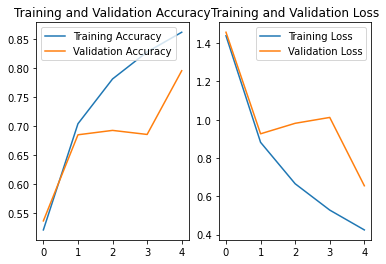

In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model

np.set_printoptions(threshold=np.inf)
#可以通过微调学习率等参数使准确率达到百分之九十以上
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


class ResnetBlock(Model):

    def __init__(self, filters, strides=1, residual_path=False):
        super(ResnetBlock, self).__init__()
        self.filters = filters
        self.strides = strides
        self.residual_path = residual_path

        self.c1 = Conv2D(filters, (3, 3), strides=strides, padding='same', use_bias=False)
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')

        self.c2 = Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)
        self.b2 = BatchNormalization()

        # residual_path为True时，对输入进行下采样，即用1x1的卷积核做卷积操作，保证x能和F(x)维度相同，顺利相加
        if residual_path:
            self.down_c1 = Conv2D(filters, (1, 1), strides=strides, padding='same', use_bias=False)
            self.down_b1 = BatchNormalization()
        
        self.a2 = Activation('relu')

    def call(self, inputs):
        residual = inputs  # residual等于输入值本身，即residual=x
        # 将输入通过卷积、BN层、激活层，计算F(x)
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)

        x = self.c2(x)
        y = self.b2(x)

        if self.residual_path:
            residual = self.down_c1(inputs)
            residual = self.down_b1(residual)

        out = self.a2(y + residual)  # 最后输出的是两部分的和，即F(x)+x或F(x)+Wx,再过激活函数
        return out


class ResNet18(Model):

    def __init__(self, block_list, initial_filters=64):  # block_list表示每个block有几个卷积层
        super(ResNet18, self).__init__()
        self.num_blocks = len(block_list)  # 共有几个block
        self.block_list = block_list
        self.out_filters = initial_filters
        self.c1 = Conv2D(self.out_filters, (3, 3), strides=1, padding='same', use_bias=False)
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')
        self.blocks = tf.keras.models.Sequential()
        # 构建ResNet网络结构
        for block_id in range(len(block_list)):  # 第几个resnet block
            for layer_id in range(block_list[block_id]):  # 第几个卷积层

                if block_id != 0 and layer_id == 0:  # 对除第一个block以外的每个block的输入进行下采样
                    block = ResnetBlock(self.out_filters, strides=2, residual_path=True)
                else:
                    block = ResnetBlock(self.out_filters, residual_path=False)
                self.blocks.add(block)  # 将构建好的block加入resnet
            self.out_filters *= 2  # 下一个block的卷积核数是上一个block的2倍
        self.p1 = tf.keras.layers.GlobalAveragePooling2D()
        self.f1 = tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())

    def call(self, inputs):
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)
        x = self.blocks(x)
        x = self.p1(x)
        y = self.f1(x)
        return y


model = ResNet18([2, 2, 2, 2])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = "./checkpoint/ResNet18.ckpt"
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])
model.summary()

# print(model.trainable_variables)
file = open('./weights.txt', 'w')
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

###############################################    show   ###############################################

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
